<a href="https://colab.research.google.com/github/jktluna/WasteReduxImageClassification/blob/main/ImageClassification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 783.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: tensorboard
    Found existing installation: 

In [2]:
!pip install tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import InputLayer
from tensorflow.keras import layers

In [4]:
data_train_path = 'basedata/train'
data_test_path = 'basedata/test'
data_val_path = 'basedata/validation'

In [5]:
img_width = 180
img_height = 180

In [6]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle = True,
    image_size = (img_width, img_height),
    batch_size = 32,
    validation_split = False)

Found 1748 files belonging to 3 classes.


In [7]:
data_cat = data_train.class_names

In [8]:
data_val = tf.keras.utils.image_dataset_from_directory(data_val_path,
                                                      image_size=(img_height, img_width),
                                                      batch_size=32,
                                                      shuffle=False,
                                                      validation_split=False)

Found 1748 files belonging to 3 classes.


In [9]:
data_test = tf.keras.utils.image_dataset_from_directory(data_test_path,
                                                      image_size=(img_height, img_width),
                                                      batch_size=32,
                                                      shuffle=False,
                                                      validation_split=False)

Found 1748 files belonging to 3 classes.


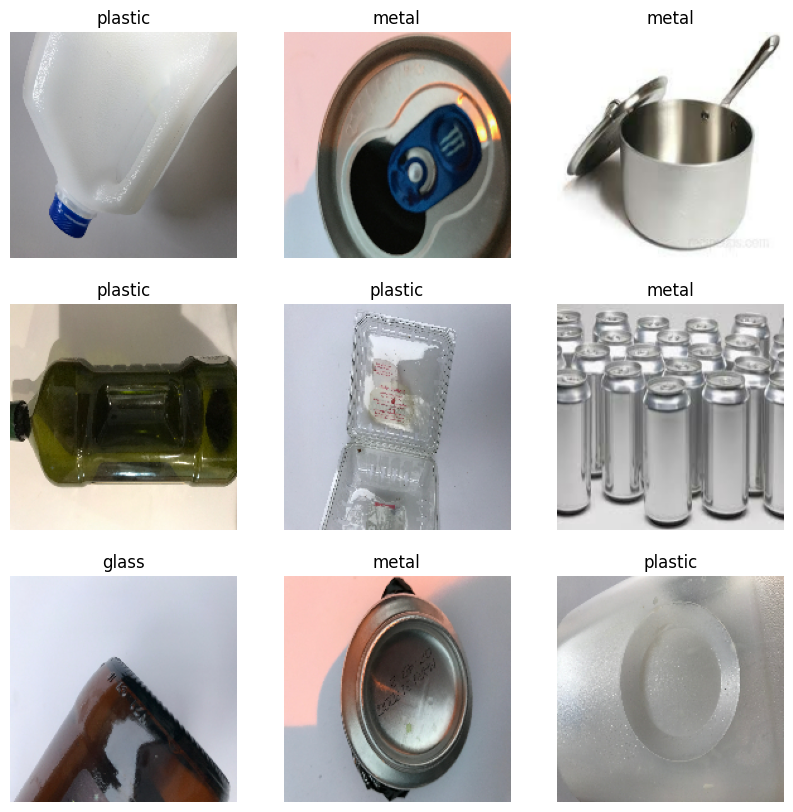

In [10]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')
plt.show()

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, GlobalAveragePooling2D, Dropout, Dense

In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
model = Sequential([
    InputLayer(shape=(img_height, img_width, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(len(data_cat), activation='softmax')  # Assuming a multi-class classification task
])

In [14]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [15]:
epochs_size = 25
history = model.fit(data_train, validation_data=data_val, epochs=epochs_size)

Epoch 1/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 566s 10s/step - accuracy: 0.5331 - loss: 1.3925 - val_accuracy: 0.8232 - val_loss: 0.4626
Epoch 2/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 592s 11s/step - accuracy: 0.7977 - loss: 0.4950 - val_accuracy: 0.8976 - val_loss: 0.2917
Epoch 3/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 596s 11s/step - accuracy: 0.8600 - loss: 0.3557 - val_accuracy: 0.9119 - val_loss: 0.2363
Epoch 4/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 576s 10s/step - accuracy: 0.8865 - loss: 0.2766 - val_accuracy: 0.9542 - val_loss: 0.1545
Epoch 5/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 606s 11s/step - accuracy: 0.9172 - loss: 0.2016 - val_accuracy: 0.9662 - val_loss: 0.1226
Epoch 6/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 552s 10s/step - accuracy: 0.9356 - loss: 0.1624 - val_accuracy: 0.9725 - val_loss: 0.0943
Epoch 7/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 605s 11s/step - accuracy: 0.9442 - loss: 0.1633 - val_accuracy: 0.9846 - val_loss: 0.0711
Epoch 8/25
55/55 ━━━━━━━━━━━━━━━━━━━━ 541s 10s/step - accuracy: 0.9428 - loss: 0.1407 - val_accuracy: 0.

In [16]:
epochs_range = range(epochs_size)
plt.figure(figsize=(12,6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

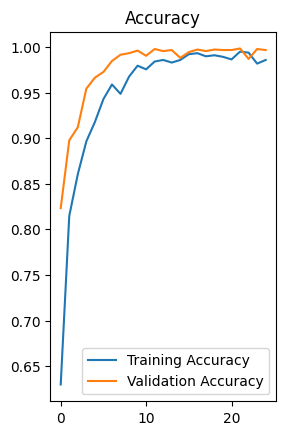

In [17]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

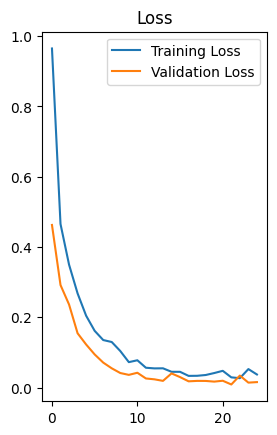

In [18]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend(loc='upper right')

plt.show()

In [20]:
image = 'met.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.img_to_array(image)
img_bat = tf.expand_dims(img_arr, 0)

predict = model.predict(img_bat)
score = tf.nn.softmax(predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Trash in Image is metal with ACCURACY of 57.61%


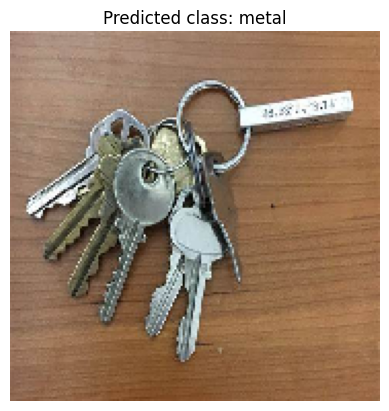

In [21]:
print('Trash in Image is {} with ACCURACY of {:0.2f}%'.format(data_cat[np.argmax(score)], np.max(score)*100))

plt.figure(dpi=100)
plt.imshow(image)  # Use the loaded image directly
plt.title(f"Predicted class: {data_cat[np.argmax(score)]}")
plt.axis('off')
plt.show()

In [22]:
import tensorflow_model_optimization as tfmot
print(tfmot.__file__)

/usr/local/lib/python3.10/dist-packages/tensorflow_model_optimization/__init__.py


In [24]:
model.export('./saved_model')

Saved artifact at './saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136068866066208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068890805872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068890461632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068890462864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068890460928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068890462688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068890470960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068890475712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068890906288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136068890903824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1360688909025

In [25]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

In [ ]:
len(tflite_model)

95009784

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [ ]:
len(tflite_quant_model)

24180144

In [30]:
import tensorflow_model_optimization as tfmot

# Define a quantize scope for model conversion
with tfmot.quantization.keras.quantize_scope():
    try:
        # Attempt to quantize the Sequential model directly
        quantize_model = tfmot.quantization.keras.quantize_apply
        q_aware_model = quantize_model(model)

        # Recompile the quantized model
        q_aware_model.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

        q_aware_model.summary()

        # Optionally, save the quantized model to an h5 file
        q_aware_model.save('quantized_model_direct.h5')
        print("Quantized model saved as 'quantized_model_direct.h5'.")
    except Exception as e:
        print(f"Direct quantization error: {e}")



Direct quantization error: `model` can only be a `keras.Model` instance.You passed an instance of type: Sequential.


In [31]:
print(type(model))


<class 'keras.src.models.sequential.Sequential'>


In [ ]:
import tensorflowjs as tfjs

In [ ]:
model.save('model.keras')

In [ ]:
model.save('model.h5')


In [ ]:
import numpy as np
print(np.__version__)

1.26.4
